In [2]:
import networkx as nx
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score

import numpy as np
import pandas as pd
from datetime import datetime

from collections import Counter
import itertools

from math import comb, ceil
from scipy import stats
import random
import string

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from tqdm import tqdm

import multiprocessing as mp

import pickle

import sys
sys.path.insert(1, '../scripts')
import modeling_v3

import importlib
importlib.reload(modeling_v3)

import matplotlib.ticker as plticker
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 14

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def network_out_of_relationships(rel):
    g = nx.Graph()

    for p1, v in rel.items():
        g.add_node(p1)
        for p2, s in v.items():
            if s!=0:
                g.add_edge(p1,p2)
    
    return g

In [4]:
def connected_components(rel):
    g = network_out_of_relationships(rel)
    
    return [len(cc) for cc in nx.connected_components(g)]

In [5]:
def multi_agent_simulation(random_seed = 89, n_beliefs = 6, m = 15, gamma = .7, n_agents = 2, last_step = 50000, sigma = .3, times_more_likely = 1):
    
    np.random.seed(random_seed)
    random.seed(random_seed)

    # initialize the belief network
    bn = modeling_v3.create_belief_network(m = m,
                                            n_beliefs = n_beliefs,
                                            complete = True)

    # initialize the agent
    agents = modeling_v3.init_agents(bn, n_agents)

    propositions = [*bn.nodes()]
    print(propositions)
    prop_combs = [*itertools.combinations(propositions, 2)]
    agent_list = [*agents.keys()]

    ratios = np.array([times_more_likely] + [1]*5)
    probs = ratios/sum(ratios)
    print(probs)

    simulation_steps = [*range(last_step+1)]
    track = {}

    conveyed = []

    for t in simulation_steps:

        i, j = np.random.choice(agent_list, 2, replace=False) # choose an agent to be the sender and the other one will be the receiver

        # choose a message with biased probabilities to convey
        b1 = np.random.choice(propositions, 1, p=probs)[0]
        
        # the second belief depends on the relationship between belief 1 and 2
        relationships, likelihoods = modeling_v3.determine_relationships_likelihoods(agents[i]['association_matrix'], gamma)
        
        choices = [k for k,v in relationships[b1].items() if v != 0]

        if len(choices) == 0: # if the node is irrelevant to the others, choose one randomly
            temp = propositions.copy()
            temp.remove(b1)
            b2 = np.random.choice(temp)
        
        else: # else, choose one among relevants
            b2 = np.random.choice(choices)

        beliefs_to_convey = [b1, b2]
        conveyed.append(beliefs_to_convey)
        
        message_to_convey = modeling_v3.deduce_message_to_convey(beliefs_to_convey, agents[i]['beliefs']) # deduce the message to convey

        # update the agent's association matrix accordingly
        modeling_v3.update_association_matrix(message_to_convey, agents[j]['association_matrix'])
        
        # assess the relationships and likelihoods of two propositions being exhibited together
        relationships, likelihoods = modeling_v3.determine_relationships_likelihoods(agents[j]['association_matrix'], gamma)

        # update agent's belief randomly
        beliefs_new = modeling_v3.update_belief(message_to_convey['e1'], agents[j]['beliefs'], sigma)
        
        # extract the relationship
        relationship = relationships[b1][b2]

        if relationship != 0:

            energy_t = modeling_v3.energy_one_agent(beliefs = agents[j]['beliefs'],
                                                    relationships = relationships,
                                                    gamma = gamma,
                                                    pairs = prop_combs)
            
            energy_t_plus_1 = modeling_v3.energy_one_agent(beliefs = beliefs_new,
                                                    relationships = relationships,
                                                    gamma = gamma,
                                                    pairs = prop_combs)

            if energy_t_plus_1 < energy_t:
                agents[j]['beliefs'] = beliefs_new
        
        if t % 2000 == 0:
            track[t] = {}
            track[t]['beliefs'] = np.array([[*a['beliefs'].values()] for a in agents.values()]).copy()

            # Internal energies
            internal_energies = modeling_v3.total_energy(agents, gamma)
            track[t]['internal_energies'] = internal_energies

            # Belief similarity
            pairwise_belief_dist = modeling_v3.belief_distances(agents)
            track[t]['pairwise_belief_dist'] = pairwise_belief_dist

            # Compute the interpretative distance between agents
            likelihoods_all_agents = {}
            for agent, v in agents.items():
                r, l = modeling_v3.determine_relationships_likelihoods(v['association_matrix'], gamma)
                likelihoods_all_agents[agent] = l
            
            interpretative_dist = interpretative_agreement(likelihoods_all_agents, prop_combs)
            track[t]['interpretative_dist'] = interpretative_dist
            track[t]['likelihoods_all_agents'] = likelihoods_all_agents

            relationships_0, likelihoods = modeling_v3.determine_relationships_likelihoods(agents[0]['association_matrix'], gamma)
            relationships_1, likelihoods = modeling_v3.determine_relationships_likelihoods(agents[1]['association_matrix'], gamma)
            track[t]['relationships'] = {0:relationships_0.copy(), 1:relationships_1.copy()}
            track[t]['association_matrices'] = {0:agents[0]['association_matrix'].copy(), 1:agents[1]['association_matrix'].copy()}
            
    return track, conveyed

In [216]:
a = multi_agent_simulation(random_seed = 33, n_beliefs = 6, m = 15, gamma = .7, n_agents = 2, last_step = 5000, sigma = .3, times_more_likely = 5)

['A', 'B', 'C', 'D', 'E', 'F']
[0.5 0.1 0.1 0.1 0.1 0.1]


In [217]:
Counter([i[0] for i in a[1]])

Counter({'A': 2505, 'C': 537, 'B': 513, 'D': 498, 'F': 476, 'E': 472})

In [219]:
Counter([i[1] for i in a[1]])

Counter({'D': 2723, 'F': 725, 'E': 537, 'C': 472, 'A': 286, 'B': 258})

In [218]:
Counter(modeling_v3.flatten(a[1]))

Counter({'D': 3221, 'A': 2791, 'F': 1201, 'C': 1009, 'E': 1009, 'B': 771})

In [181]:
a[0][4000].keys()

dict_keys(['beliefs', 'internal_energies', 'pairwise_belief_dist', 'interpretative_dist', 'likelihoods_all_agents', 'relationships', 'association_matrices'])

In [220]:
a[0][4000]['relationships']

{0: {'A': {'B': 0, 'C': 0, 'D': 1, 'E': 0, 'F': 0, 'A': 0},
  'B': {'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': -1, 'B': 0},
  'C': {'A': 0, 'B': 0, 'D': 0, 'E': -1, 'F': 0, 'C': 0},
  'D': {'A': 1, 'B': 0, 'C': 0, 'E': 0, 'F': 1, 'D': 0},
  'E': {'A': 0, 'B': 0, 'C': -1, 'D': 0, 'F': 0, 'E': 0},
  'F': {'A': 0, 'B': -1, 'C': 0, 'D': 1, 'E': 0, 'F': 0}},
 1: {'A': {'B': 0, 'C': 0, 'D': 1, 'E': 0, 'F': 0, 'A': 0},
  'B': {'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': -1, 'B': 0},
  'C': {'A': 0, 'B': 0, 'D': 0, 'E': -1, 'F': 0, 'C': 0},
  'D': {'A': 1, 'B': 0, 'C': 0, 'E': 0, 'F': 1, 'D': 0},
  'E': {'A': 0, 'B': 0, 'C': -1, 'D': 0, 'F': 0, 'E': 0},
  'F': {'A': 0, 'B': -1, 'C': 0, 'D': 1, 'E': 0, 'F': 0}}}

In [165]:
das = [np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], 1, p=probs)[0] for i in range(10000)]

In [166]:
Counter(das)

Counter({'A': 2010, 'F': 1643, 'E': 1612, 'C': 1596, 'D': 1577, 'B': 1562})

In [9]:
def interpretative_agreement(likelihoods_all_agents, prop_combs):
    
    likelihood_piles = []

    for agent, v in likelihoods_all_agents.items():
        _ = []
        for p1, p2 in prop_combs:
            _.append(v[p1][p2])
        
        likelihood_piles.append(_)

    pairwise_dist = pairwise_distances(np.array(likelihood_piles), metric='manhattan')
    
    return np.mean(pairwise_dist[np.triu_indices_from(pairwise_dist, k=1)])

In [85]:
propositions = [*l[0].keys()]
prop_combs = [*itertools.combinations(propositions, 2)]

[[-1 -1 -1 -1 -1 -1]
 [ 1  1  1 -1 -1  1]]


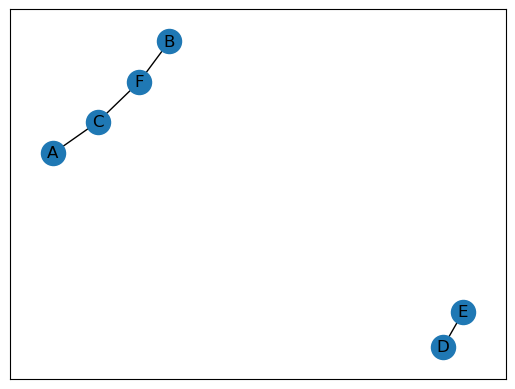

In [192]:
check = multi_agent_simulation(random_seed=65, n_beliefs=6, m=15, gamma=0.7, n_agents=2, last_step=2000, sigma=0.1, times_more_likely=1)
print(check[2000]['beliefs'])
nx.draw_networkx(network_out_of_relationships(check[2000]['relationships'][0]))

In [ ]:
modeling_v3.energy_comprehensive(message_to_convey, beliefs, relationships)

In [13]:
n_beliefs = 6
m = 15
gamma_vals = [0, .6, .7, .8]
n_agents = 100
last_step = 500000
sigma = .3
times_more_likely = 1.3
repetition = 10

track = {}

for gamma in gamma_vals:
    print(gamma)
    track[gamma] = {}

    random_states = [np.random.randint(0, 100000) for i in range(repetition)]    
    
    params = [*zip(random_states,
                    [n_beliefs] * repetition, 
                    [m] * repetition,
                    [gamma] * repetition,
                    [n_agents] * repetition,
                    [last_step] * repetition,
                    [sigma] * repetition,
                    [times_more_likely] * repetition)]

    pool = mp.Pool(processes=20)
    temp = pool.starmap(multi_agent_simulation, params, chunksize=1)
    pool.close()

    track[gamma] = temp
    del temp

0
0.6
0.7
0.8


In [14]:
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
with open(f'../data/results_multi_agent_biased_{dt_string}.pkl', 'wb') as f:
    pickle.dump(track, f)

# Analyze the Results

In [30]:
with open('/media/volume/data/pairwise_diffusion/data/results_multi_agent_biased_10_08_2024_06_24_02.pkl', 'rb') as f:
    track = pickle.load(f)

### Pairwise Belief Similarities At the End

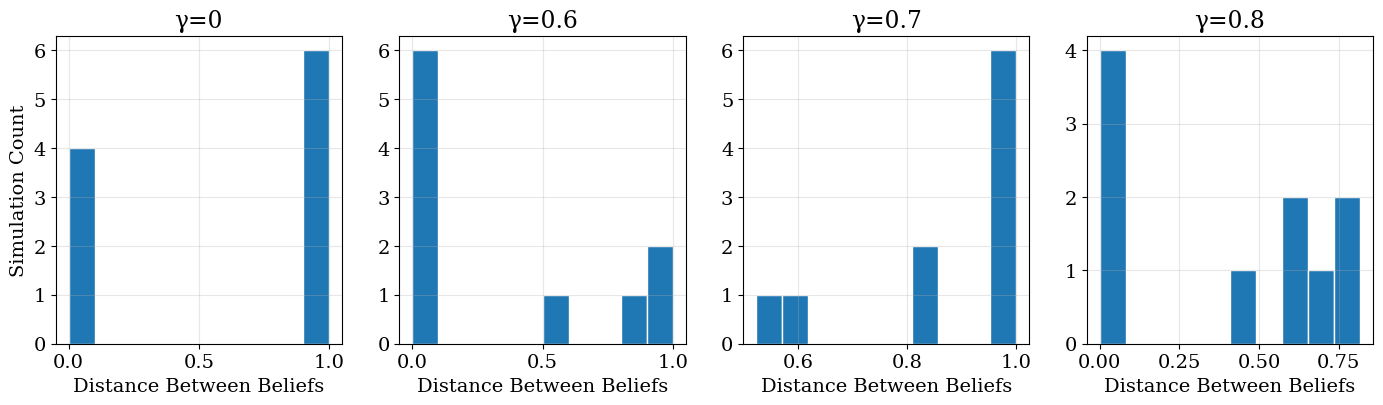

In [31]:
T = 4.89897949

fig, axs = plt.subplots(1,4, figsize=(17,4))
for col, gamma in zip([0, 1, 2, 3], [0, .6, .7, .8]):
    #axs[col].hist([((track[gamma][s][10000]['pairwise_belief_dist'])/T)[0] for s in range(100) if sum(track[gamma][s][10000]['internal_energies'])==-2], edgecolor='white')
    axs[col].hist([((track[gamma][s][500000]['pairwise_belief_dist'])/T)[0] for s in range(10)], edgecolor='white')
    axs[col].grid(alpha=.3)
    axs[col].set_title(f'γ={gamma}')
    axs[col].set_xlabel('Distance Between Beliefs')

axs[0].set_ylabel('Simulation Count')

#fig.savefig('../figures/two_agents_belief_distance.pdf')
fig.show()

In [35]:
track[.7][8][50000]['relationships']

{0: {'A': {'B': -1, 'C': 0, 'D': 0, 'E': -1, 'F': -1, 'A': 0},
  'B': {'A': -1, 'C': 0, 'D': 0, 'E': 0, 'F': 1, 'B': 0},
  'C': {'A': 0, 'B': 0, 'D': 1, 'E': 0, 'F': 0, 'C': 0},
  'D': {'A': 0, 'B': 0, 'C': 1, 'E': 0, 'F': 0, 'D': 0},
  'E': {'A': -1, 'B': 0, 'C': 0, 'D': 0, 'F': 0, 'E': 0},
  'F': {'A': -1, 'B': 1, 'C': 0, 'D': 0, 'E': 0, 'F': 0}},
 1: {'A': {'B': -1, 'C': 0, 'D': 0, 'E': -1, 'F': -1, 'A': 0},
  'B': {'A': -1, 'C': 0, 'D': 0, 'E': 0, 'F': 1, 'B': 0},
  'C': {'A': 0, 'B': 0, 'D': 1, 'E': 0, 'F': 0, 'C': 0},
  'D': {'A': 0, 'B': 0, 'C': 1, 'E': 0, 'F': 0, 'D': 0},
  'E': {'A': -1, 'B': 0, 'C': 0, 'D': 0, 'F': 0, 'E': 0},
  'F': {'A': -1, 'B': 1, 'C': 0, 'D': 0, 'E': 0, 'F': 0}}}

### Internal Energy and Interpretative Distance

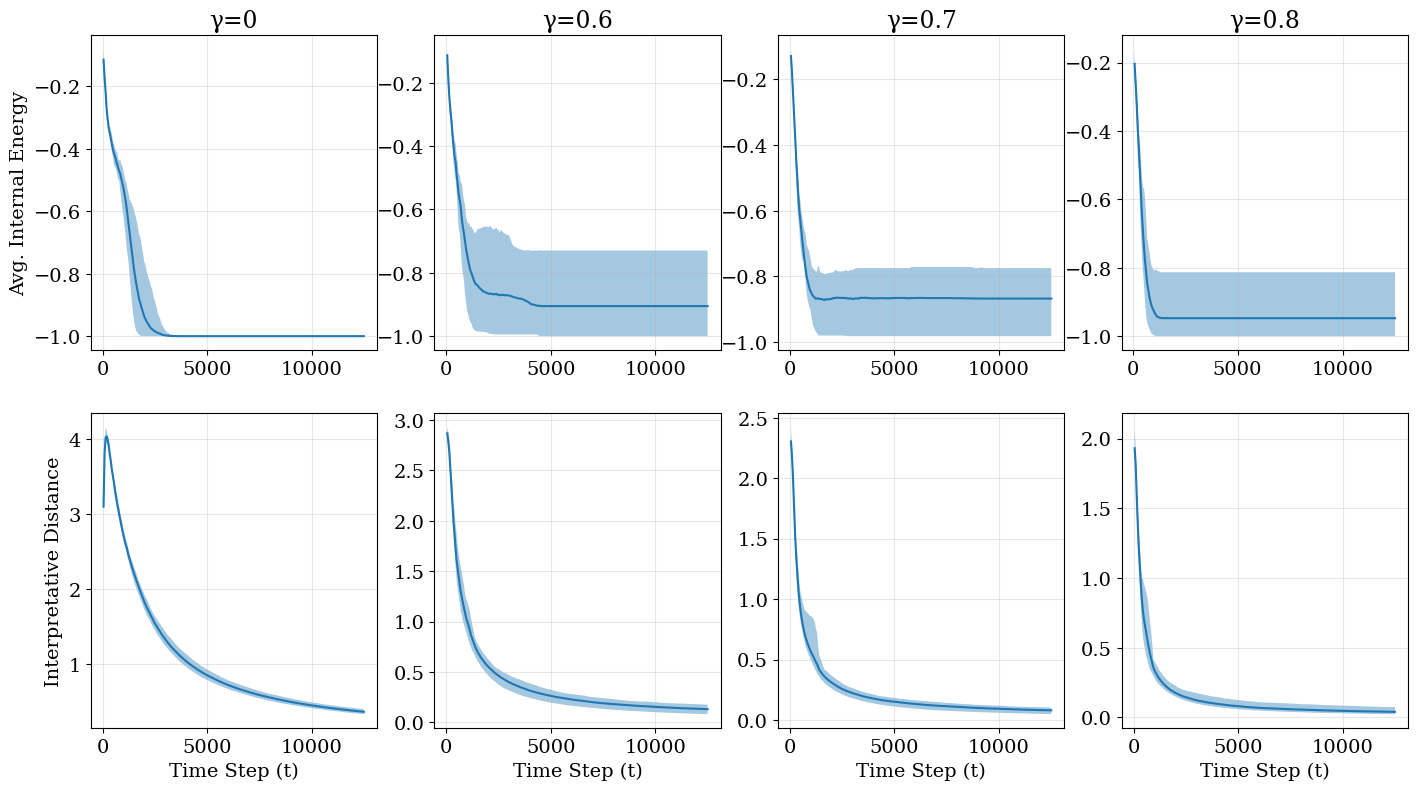

In [32]:
fig, axs = plt.subplots(2,4,figsize=(17,9))

repetition = 10

for col, gamma in zip([0,1,2,3], [0, .6, .7, .8]):
    arr_ie = np.array([[np.mean(v['internal_energies']) for v in track[gamma][s].values()] for s in range(repetition)])
    arr_id = np.array([[v['interpretative_dist'] for v in track[gamma][s].values()] for s in range(repetition)])
    x = [i*50 for i in range(len(track[gamma][0]))]

    for row, arr in zip([0,1], [arr_ie, arr_id]):
        mean = np.mean(arr, axis=0)[1:]
        axs[row][col].plot(x[1:], mean)
        axs[row][col].fill_between(x=x[1:], y1=np.percentile(arr, axis=0, q=97.5)[1:], y2=np.percentile(arr, axis=0, q=2.5)[1:], alpha=.4)
        axs[row][col].grid(alpha=.3)
        #axs[row][col].set_xscale('log')
    
    axs[0][col].set_title(f'γ={gamma}')
    axs[1][col].set_xlabel('Time Step (t)')

axs[0][0].set_ylabel('Avg. Internal Energy')
axs[1][0].set_ylabel('Interpretative Distance')

#fig.savefig('../figures/two_agents_id_ie.pdf')

fig.show()

## Analyzing Multi Agent Model

In [6]:
with open('/media/volume/data/pairwise_diffusion/data/results_multi_agent_21_07_2024_09_47_25.pkl', 'rb') as f:
    track = pickle.load(f)

In [36]:
gamma = 0
len([((track[gamma][s][100000]['pairwise_belief_dist'])/T)[0] for s in range(100) if ((track[gamma][s][100000]['pairwise_belief_dist'])/T)[0]<0.90])

63

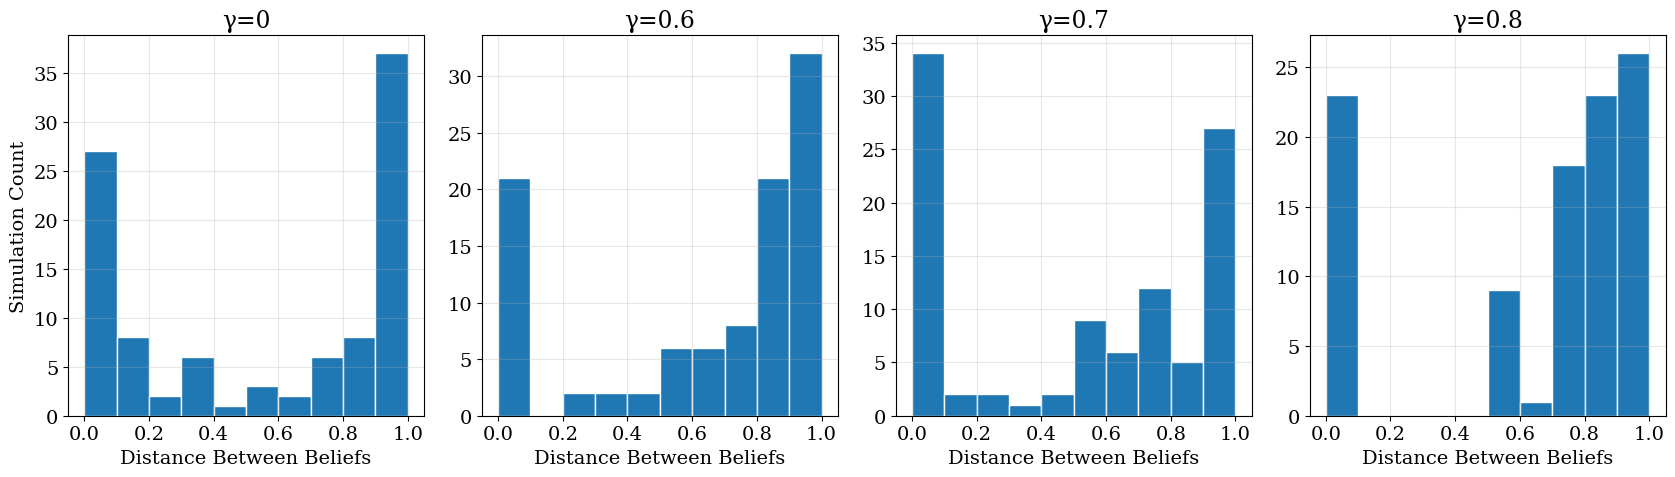

In [15]:
T = 4.89897949

fig, axs = plt.subplots(1,4, figsize=(17,5))
for col, gamma in zip([0, 1, 2, 3], [0, .6, .7, .8]):
    #axs[col].hist([((track[gamma][s][10000]['pairwise_belief_dist'])/T)[0] for s in range(100) if sum(track[gamma][s][10000]['internal_energies'])==-2], edgecolor='white')
    axs[col].hist([((track[gamma][s][100000]['pairwise_belief_dist'])/T)[0] for s in range(100)], edgecolor='white')
    axs[col].grid(alpha=.3)
    axs[col].set_title(f'γ={gamma}')
    axs[col].set_xlabel('Distance Between Beliefs')

axs[0].set_ylabel('Simulation Count')

fig.tight_layout()
#fig.savefig('../figures/multi_agent_belief_distance.pdf')
fig.show()

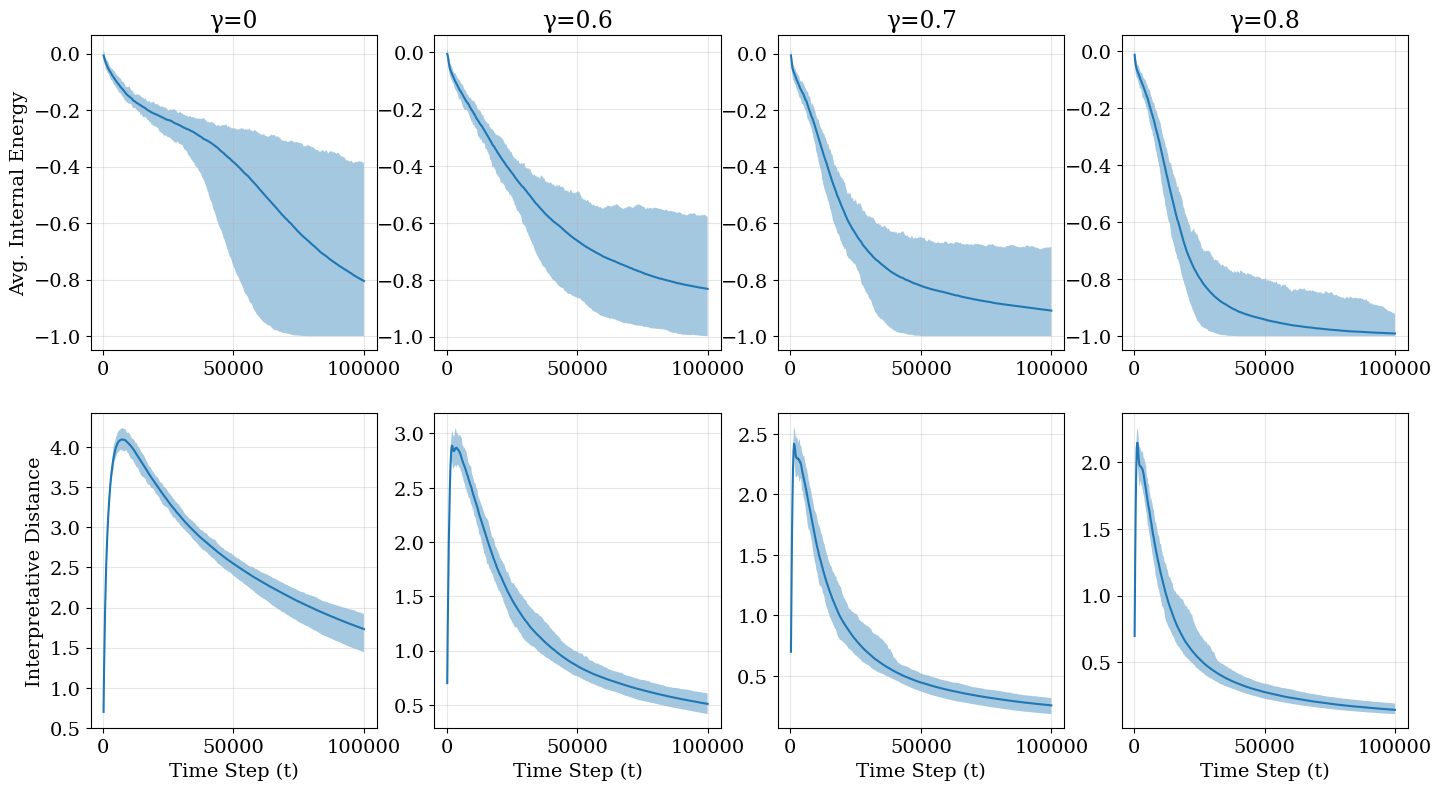

In [37]:
fig, axs = plt.subplots(2,4,figsize=(17,9))

for col, gamma in zip([0,1,2,3], [0, .6, .7, .8]):
    arr_ie = np.array([[np.mean(v['internal_energies']) for v in track[gamma][s].values()] for s in range(100)])
    arr_id = np.array([[v['interpretative_dist'] for v in track[gamma][s].values()] for s in range(100)])
    arr_cc = np.array([[v['interpretative_dist'] for v in track[gamma][s].values()] for s in range(100)])
    x = [i*200 for i in range(len(track[gamma][0]))]

    for row, arr in zip([0,1], [arr_ie, arr_id]):
        mean = np.mean(arr, axis=0)[1:]
        axs[row][col].plot(x[1:], mean)
        axs[row][col].fill_between(x=x[1:], y1=np.percentile(arr, axis=0, q=97.5)[1:], y2=np.percentile(arr, axis=0, q=2.5)[1:], alpha=.4)
        axs[row][col].grid(alpha=.3)
        #axs[row][col].set_xscale('log')
    
    axs[0][col].set_title(f'γ={gamma}')
    axs[1][col].set_xlabel('Time Step (t)')

axs[0][0].set_ylabel('Avg. Internal Energy')
axs[1][0].set_ylabel('Interpretative Distance')

#fig.savefig('../figures/multi_agent_id_ie.pdf')

fig.show()

In [62]:
for gamma in [0, .6, .7, .8]:
    arr_cc = np.array([[v['cluster_count'] for v in track[gamma][s].values()] for s in range(100)])
    print(np.median(arr_cc[:, -1]))

2.0
3.0
5.0
4.0


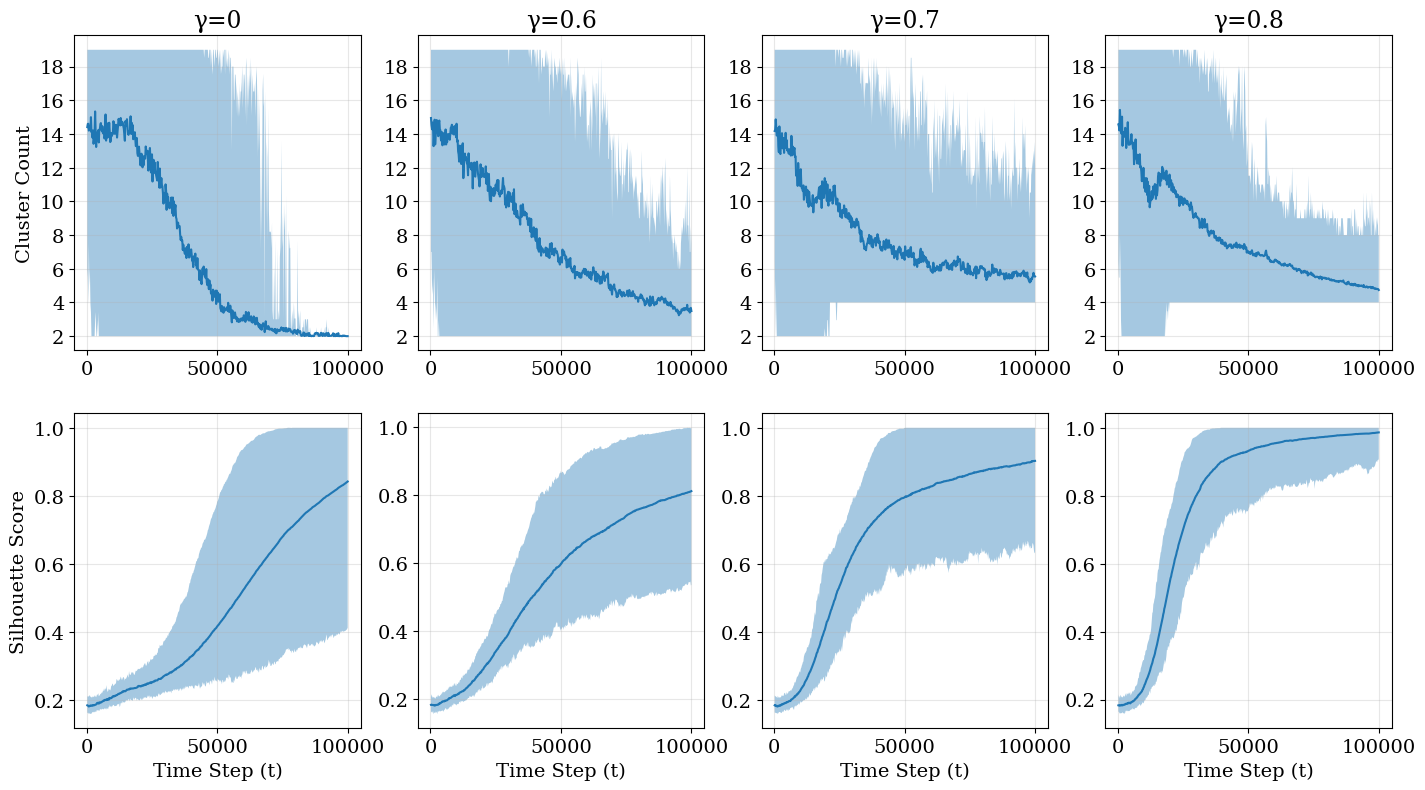

In [42]:
fig, axs = plt.subplots(2,4,figsize=(17,9))

for col, gamma in zip([0,1,2,3], [0, .6, .7, .8]):
    arr_cc = np.array([[v['cluster_count'] for v in track[gamma][s].values()] for s in range(100)])
    arr_ss = np.array([[v['silhouette_score'] for v in track[gamma][s].values()] for s in range(100)])
    x = [i*200 for i in range(len(track[gamma][0]))]

    for row, arr in zip([0,1], [arr_cc, arr_ss]):
        mean = np.mean(arr, axis=0)[1:]
        axs[row][col].plot(x[1:], mean)
        axs[row][col].fill_between(x=x[1:], y1=np.percentile(arr, axis=0, q=97.5)[1:], y2=np.percentile(arr, axis=0, q=2.5)[1:], alpha=.4)
        axs[row][col].grid(alpha=.3)

        if row == 0:
            axs[row][col].yaxis.set_major_locator(plticker.MultipleLocator(2))
        #axs[row][col].set_xscale('log')
    
    axs[0][col].set_title(f'γ={gamma}')
    axs[1][col].set_xlabel('Time Step (t)')

axs[0][0].set_ylabel('Cluster Count')
axs[1][0].set_ylabel('Silhouette Score')

fig.savefig('../figures/multi_agent_clustering.pdf')

fig.show()